Author: Bram van Duinen

Date last edited: 20 nov 2023

Content: This notebook takes the co_occurences calculated in calc_co-occur and plots these on maps for each countries. Figures are saved in the Figures folder, with a subfolder produced for the date of the run.

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import cartopy
from cartopy.io import shapereader
import cartopy.crs as ccrs
import geopandas
import numpy as np
from datetime import datetime, timedelta
import os
from tqdm.notebook import tqdm

In [5]:
rundate_co_occur = 20231120
co_occurrences = np.load(f'../Results/co_occurrences_{rundate_co_occur}.npy')

date_now = datetime.now()
rundate = '%4.4i%2.2i%2.2i' % (date_now.year,date_now.month,date_now.day)
# Create folders for Figures from today
dir_Figures_country = f'../Results/Figures/{rundate}/countrymaps'

if not os.path.exists(dir_Figures_country):
    print('Creating dir %s' % dir_Figures_country)
    os.makedirs(dir_Figures_country)

  0%|          | 0/35 [00:00<?, ?it/s]

KeyboardInterrupt: 

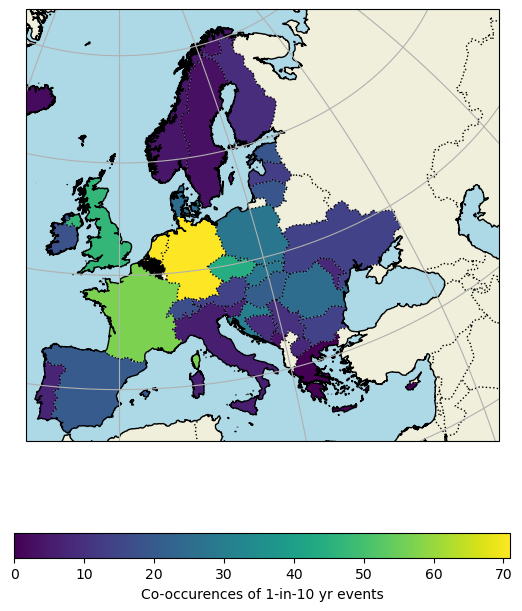

In [13]:
basecountry_id = 0
# get natural earth data (http://www.naturalearthdata.com/)
for basecountry_id in tqdm(range(len(co_occurrences))):
    # get country borders
    resolution = '10m'
    category = 'cultural'
    name = 'admin_0_countries'
    shpfilename = shapereader.natural_earth(resolution, category, name)

    # read the shapefile using geopandas
    df = geopandas.read_file(shpfilename)

    # Set up the canvas
    fig = plt.figure(figsize=(8, 8))
    central_lon, central_lat = 0, 45
    extent = [-10, 45, 35, 70]
    ax = plt.axes(projection=cartopy.crs.Orthographic(central_lon, central_lat))
    ax.set_extent(extent)
    ax.gridlines()

    # Add natural earth features and borders
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':', alpha=1)
    ax.add_feature(cartopy.feature.OCEAN, facecolor=("lightblue"))
    ax.add_feature(cartopy.feature.LAND)
    ax.coastlines(resolution='10m')

    # Insert your lists of countries and lag times here

    countries = ['AUT', 'BEL', 'BGR', 'BIH', 'CHE', 'CYP', 'CZE', 'DEU', 'DNK', 'ESP', 'EST', 'FIN',
            'FRA', 'GBR', 'GRC', 'HRV', 'HUN', 'IRL', 'ISL', 'ITA', 'LTU', 'LVA', 'MDA', 'MKD',
            'MNE', 'NLD', 'NOR', 'POL', 'PRT', 'ROU', 'SRB', 'SVK', 'SVN', 'SWE', 'UKR']
    co_occur = co_occurrences[basecountry_id]

    # Normalise the lag times to between 0 and 1 to extract the colour
    co_occur_norm = (co_occur-np.nanmin(co_occur))/(np.nanmax(co_occur) - np.nanmin(co_occur))

    # Choose your colourmap here
    cmap = matplotlib.colormaps["viridis"]


    for country, lag_norm in zip(countries, co_occur_norm):
        # read the borders of the country in this loop
        poly = df.loc[df['ISO_A3_EH'] == country]['geometry'].values[0]
        # get the color for this country
        rgba = cmap(lag_norm)
        # plot the country on a map
        ax.add_geometries(poly, crs=ccrs.PlateCarree(), facecolor=rgba, edgecolor='none', zorder=1)

    poly = df.loc[df['ISO_A3_EH'] == countries[basecountry_id]]['geometry'].values[0]
    ax.add_geometries(poly, crs=ccrs.PlateCarree(), facecolor='k', edgecolor='none', zorder=1)
    # Add a scatter plot of the original data so the colorbar has the correct numbers. Hacky but it works
    dummy_scat = ax.scatter(co_occur, co_occur, c=co_occur, cmap=cmap, zorder=0)
    fig.colorbar(mappable=dummy_scat, label='Co-occurences of 1-in-10 yr events', orientation='horizontal', shrink=0.8)
    plt.savefig(f'{dir_Figures_country}/{countries[basecountry_id]}_Co-occurrences.png', dpi=300, bbox_inches='tight')
    plt.close()